In [1]:
import torch
from torch.distributions import Categorical
import random
import itertools
import numpy as np
import copy
import torch
from torch import nn
from torch.nn import functional as F
from copy import deepcopy
import math 
import numpy as np
from Model.Config import *
from Model.AMO import * 
from Ant_k_starts import *
from Normalize_data import *
from Ant import *
from Injection import *
from Cross_Exchange import *
from Local_search import * 
from Draw import *


tensor(2723.4431)
tensor([[ 0,  0,  0,  ...,  0,  0,  0],
        [10,  9, 43,  ..., 19, 83, 34],
        [ 6,  4,  8,  ...,  8,  8,  8],
        ...,
        [ 0,  0,  0,  ...,  0,  0,  0],
        [ 0,  0,  0,  ...,  0,  0,  0],
        [ 0,  0,  0,  ...,  0,  0,  0]])
--------


In [2]:
device = None
cfg = Data_100()

EPS = 1e-10
model = Net3().to(device)
model.load_state_dict(torch.load('AMO_ACO_{}.pt'.format(cfg.graph_size), map_location=torch.device('cpu')))

<All keys matched successfully>

In [3]:
pyg_data_normalize = normalize_data(cfg)
heuristic_measure, log, topk = model(pyg_data_normalize)
heuristic_measure = heuristic_measure.reshape((cfg.graph_size+1, cfg.graph_size+1))

In [4]:
max_cap, xcoord, ycoord, demand, e_time, l_time, s_time, data = load_data()
data = torch.tensor([[float(x) for x in y] for y in data])
tsp_coordinates = data[:, 1:3] 
demands = torch.tensor(demand, dtype = torch.float32)
time_window = data[:, 4:]
durations = time_window[:, -1] 
distances = gen_distance_matrix(tsp_coordinates, device = device)

aco = ACO(distances, demands, time_window, 10, topk, max_cap, heuristic=heuristic_measure, n_ants=cfg.n_ants)

In [5]:
max_cap, xcoord, ycoord, demand, e_time, l_time, s_time, data = load_data()

CAP=max_cap
colony=Ant(data,CAP,0.7, heuristic_measure)
colony.customer_cord()
colony.euclidean_distance()
colony.width_window()
_ = colony.path_pheromon()

In [6]:
def convert_dict(path): # path: tensor depot 0(m,)
    path += 1
    path = path.to(torch.long)
    zero_indices = torch.where(path == 1)[0]
    zero_indices = zero_indices.tolist()
    path = path.tolist()
    while zero_indices[-1] - zero_indices[-2] == 1:
        zero_indices.pop()
    dict = {}
    for i in range(len(zero_indices) - 1):
        dict[i] = path[zero_indices[i]: zero_indices[i+1] + 1 ]
    return dict

In [7]:
def update_btnt(path, cost, pheromone, effort, k_candidate, prob_to_update, reward_coff, best_cost):
    '''
    path: Loi giai tiem nang
    cost: ham cost cua loi giai
    pheromone: aco.pheromone
    effort: so iter truoc khi ket thuc
    '''
    if cost < best_cost:
        reward = int(k_candidate * prob_to_update * reward_coff) * effort
    else:
        reward = int(k_candidate * prob_to_update) * effort
    for route in path.values(): # route
        for l in range(len(route) - 1):
            pheromone[int(route[l] - 1)][int(route[l+1] - 1)] += reward/cost
    reward_coff += 2
    return reward_coff, pheromone
    

In [8]:

max_iteration = 200
min_prob_local = 0.005
max_prob_local = 0.01
n_customer = len(data)
k_candidate = 100
prob_to_update = 0.2
best = 1e10
best_cost = 1e10
aco.decay = 1
aco.beta = 0.5
elitism_set = 0
reward_coff = 2
effort = 0
final_path = 0

cnt = 0
for k in range(max_iteration):
    paths, costs = aco.run()
    '''
    TO DO:
    - Chon 100 paths co gia tri tot nhat # DONE 
    - Xay ham chuyen paths ve dinh dang dictionary nhu BTNT_IBSO_ACO # DONE
    - Mode colony # DONE
    - Thuc hien Injection va Cross Exchange # DONE 
    - Thuc hien Local Search ngau nhien # DONE
    - Xac suat lua chon < 0.3 # DONE
    - continue
    '''
    local_path = []
    candidate_values, indexs = torch.topk(costs, k = k_candidate, largest=False)
    candidate_path = paths.T[indexs] # (k * prob_size)
    for i, (value, path) in enumerate(zip(candidate_values, candidate_path)):
        ants_route = convert_dict(path)
        travel_distance, ants_route = injection(ants_route, colony, 0.5)
        travel_distance, ants_route = cross_exchange(ants_route, colony)
        # if np.random.random() < min_prob_local + (max_prob_local - min_prob_local)*(k/(max_iteration-1)):
        #     # print('Ok')
        #     travel_distance, ants_route = local_search(ants_route, colony, n_customer)
        candidate_values[i] = travel_distance
        local_path.append(ants_route)
    
    aco.pheromone *= aco.decay
    value_to_update, index_to_update = torch.topk(candidate_values, k = int(k_candidate * prob_to_update), largest=False)
    for i, j in enumerate(index_to_update):
        path = local_path[j] # dict
        for route in path.values(): # route
            for l in range(len(route) - 1):
                if i == 0:
                    aco.pheromone[int(route[l] - 1)][int(route[l+1] - 1)] += 1/value_to_update[i]
                aco.pheromone[int(route[l] - 1)][int(route[l+1] - 1)] += 1/value_to_update[i]
    if torch.min(candidate_values) < best:
        best = torch.min(candidate_values)
        best_path = local_path[index_to_update[0]]
        if k > 0 and elitism_set != 0:
            path, cost = elitism_set
            reward_coff, pheromone = update_btnt(path, cost, aco.pheromone, effort, k_candidate, prob_to_update, reward_coff, best_cost)
            aco.pheromone = pheromone 
        elitism_set = (best_path, best)  # tuple (path, cost)
        effort = 1
        tries = 0
    
    # Alimentation:
    if tries == 2 and elitism_set != 0:
        path, cost = elitism_set
        reward_coff, pheromone = update_btnt(path, cost, aco.pheromone, effort, k_candidate, prob_to_update, reward_coff, best_cost)
        elitism_set = 0
        aco.pheromone = pheromone 
       
    if elitism_set != 0:
        ants_route, cost = elitism_set
        travel_distance, ants_route = local_search(ants_route, colony, n_customer)
        if travel_distance < cost:
           elitism_set = (ants_route, travel_distance)
           effort += 1
        if travel_distance < best_cost:
            best_cost = travel_distance 
            final_path = ants_route
        else:
           effort += 1
           tries += 1



    
    print('epoch {}: Best: {}, Alimentation: {}'.format(k, best, best_cost))



epoch 0: Best: 2162.71533203125, Alimentation: 1337.0591070277385
epoch 1: Best: 1753.526123046875, Alimentation: 1319.8128126935342
epoch 2: Best: 1679.4805908203125, Alimentation: 1262.9839163732452
epoch 3: Best: 1679.4805908203125, Alimentation: 1131.633101776905
epoch 4: Best: 1679.4805908203125, Alimentation: 1088.5563622815512
epoch 5: Best: 1679.4805908203125, Alimentation: 1084.382409202381
epoch 6: Best: 1679.4805908203125, Alimentation: 1062.1160093525255
epoch 7: Best: 1679.4805908203125, Alimentation: 1050.194766635332
epoch 8: Best: 1679.4805908203125, Alimentation: 1038.2453840837175
epoch 9: Best: 1679.4805908203125, Alimentation: 1020.4291231939651
epoch 10: Best: 1679.4805908203125, Alimentation: 1016.051665903683
epoch 11: Best: 1679.4805908203125, Alimentation: 1015.9013436650691
epoch 12: Best: 1679.4805908203125, Alimentation: 1015.9013436650691
epoch 13: Best: 1679.4805908203125, Alimentation: 1015.9013436650691
epoch 14: Best: 1679.4805908203125, Alimentation: 1

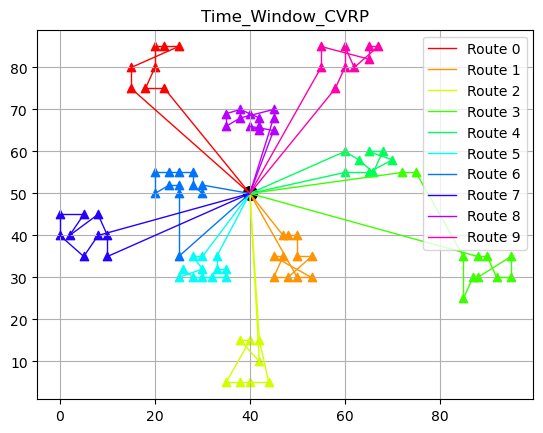

In [9]:
draw(final_path, colony)